# Combining Price Prediction LSTM with Sentiment Analysis Model for Increased Trading Strategy Performance

### Imports

In [1]:
import pandas as pd
import seaborn as sb
import pywt
import gensim
import numpy as np
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from attention import Attention
from keras.optimizers import Adam
from keras import metrics
from keras import backend as K
import keras.utils.vis_utils
from random import randint
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

### Loading the Datasets

In [2]:
historicalData = pd.read_csv("./Datasets/S&P500.csv")
sentimentData = pd.read_csv("./Datasets/SentimentData.csv")

### Check if Price History Dataset is Clean

In [3]:
nulls = historicalData.isnull().sum().sum() + historicalData.isna().sum().sum()
boolSeries = historicalData.duplicated().to_numpy()
if ((boolSeries.sum() == 0) and (nulls == 0)):
    print('Price History Dataset is clean!')
else:
    print('Price History Dataset is unclean!')

Price History Dataset is clean!


### Visualise Sentiment Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5847 entries, 0 to 5846
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5847 non-null   object
 1   Sentiment  5847 non-null   object
dtypes: object(2)
memory usage: 91.5+ KB
None


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

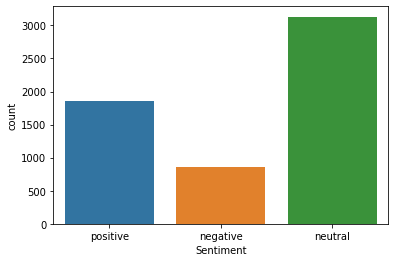

In [4]:
print(sentimentData.info())
sb.countplot(x="Sentiment", data=sentimentData)

### Sentiment Data Preprocessing

In [5]:
sentences = sentimentData["Sentence"].apply(gensim.utils.simple_preprocess)
print(sentences.head())

0    [the, geosolutions, technology, will, leverage...
1     [esi, on, lows, down, to, bk, real, possibility]
2    [for, the, last, quarter, of, componenta, net,...
3    [according, to, the, finnish, russian, chamber...
4    [the, swedish, buyout, firm, has, sold, its, r...
Name: Sentence, dtype: object


### Denominating Sentiment Labels

In [6]:
labels = sentimentData["Sentiment"].copy()

for i in range(labels.shape[0]):
    if (sentimentData["Sentiment"].iloc[i] == "positive"):
        labels.iloc[i] = 0
    elif (sentimentData["Sentiment"].iloc[i] == "neutral"):
        labels.iloc[i] = 1
    elif (sentimentData["Sentiment"].iloc[i] == "negative"):
        labels.iloc[i] = 2
        
print(labels[:5])

0    0
1    2
2    0
3    1
4    1
Name: Sentiment, dtype: object


### Build and Train Word to Vector Model

In [7]:
word2vecModel = gensim.models.Word2Vec(window=10, min_count=2, workers=4)
word2vecModel.build_vocab(sentences, progress_per=1000)
word2vecModel.train(sentences, total_examples=word2vecModel.corpus_count, epochs=100)

(7295949, 10166600)

### Building Sentiment Data Inputs and Outputs

In [8]:
maxLength = 0

for sentence in sentences:
    if (len(sentence) > maxLength):
        maxLength = len(sentence)

X = []
y = []

for i in range(sentences.shape[0]):
    sentence = sentences[i]
    wordVec = []
    # Embedding
    for word in sentence:
        if (word in word2vecModel.wv):
            wordVec.append(word2vecModel.wv[word].tolist())
    # Padding
    for j in range(maxLength-len(wordVec)):
        wordVec.append([0 for index in range(100)])
    X.append(wordVec)
    y.append(labels[i])
    
X = np.array(X)
y = np.array(y)
X = X.astype(np.float32)
y = y.astype(np.float32)

y_hot = to_categorical(y)

print(X.shape)
print(X.dtype)
print(y.shape)
print(y.dtype)
print(y_hot.shape)

(5847, 50, 100)
float32
(5847,)
float32
(5847, 3)


### Sentiment Data Train-Test Split

In [9]:
sentiment_X_train, sentiment_X_test, sentiment_y_train, sentiment_y_test = train_test_split(X, y_hot, test_size=0.1, random_state=42, shuffle=False)

print(sentiment_X_train.shape)
print(sentiment_y_train.shape)
print(sentiment_X_test.shape)
print(sentiment_y_test.shape)

(5262, 50, 100)
(5262, 3)
(585, 50, 100)
(585, 3)


### Define and Compile Sentiment Analysis Model

In [10]:
sentimentModel = Sequential()
sentimentModel.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
sentimentModel.add(Attention(units=32))
sentimentModel.add(Dense(3, activation='sigmoid'))
sentimentModelOptimiser = Adam(learning_rate=0.01)
sentimentModel.compile(loss='categorical_crossentropy', optimizer=sentimentModelOptimiser, metrics=['acc'])
print(sentimentModel.summary())

2022-08-15 21:17:31.244076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 50, 100)          60400     
 l)                                                              
                                                                 
 attention (Attention)       (None, 32)                16400     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 76,899
Trainable params: 76,899
Non-trainable params: 0
_________________________________________________________________
None


### Train Sentiment Analysis Model

In [11]:
sentimentHistory = sentimentModel.fit(sentiment_X_train, sentiment_y_train, validation_data=(sentiment_X_test, sentiment_y_test), batch_size=32, epochs=5, verbose=1)

Epoch 1/5


2022-08-15 21:17:34.054919: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


165/165 [==============================] - ETA: 0s - loss: 0.7517 - acc: 0.6807

2022-08-15 21:17:38.244682: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


165/165 [==============================] - 7s 23ms/step - loss: 0.7517 - acc: 0.6807 - val_loss: 0.7039 - val_acc: 0.7094
Epoch 2/5
165/165 [==============================] - 3s 19ms/step - loss: 0.5636 - acc: 0.7520 - val_loss: 0.6297 - val_acc: 0.7026
Epoch 3/5
165/165 [==============================] - 3s 20ms/step - loss: 0.4624 - acc: 0.7970 - val_loss: 0.6503 - val_acc: 0.7145
Epoch 4/5
165/165 [==============================] - 4s 22ms/step - loss: 0.3932 - acc: 0.8223 - val_loss: 0.7186 - val_acc: 0.7111
Epoch 5/5
165/165 [==============================] - 4s 24ms/step - loss: 0.3383 - acc: 0.8385 - val_loss: 0.7845 - val_acc: 0.7077


### Predict Sentiment

In [12]:
sentiment_y_hat = sentimentModel.predict(sentiment_X_test)

 1/19 [>.............................] - ETA: 11s

2022-08-15 21:17:53.224378: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


19/19 [==============================] - 1s 11ms/step


### Decode Sentiment Prediction

In [13]:
sentiment_y_hat_absolute = []
sentiment_y_hat_text = []

for i in range(len(sentiment_y_hat)):
    maxConfidenceScore = 0
    indexOfMaxScore = 0
    prediction = sentiment_y_hat[i]
    for j in range(len(prediction)):
        if (prediction[j] > maxConfidenceScore):
            maxConfidenceScore = prediction[j]
            indexOfMaxScore = j
    if (indexOfMaxScore == 0):
        sentiment_y_hat_absolute.append([1, 0, 0])
        sentiment_y_hat_text.append("positive")
    elif (indexOfMaxScore == 1):
        sentiment_y_hat_absolute.append([0, 1, 0])
        sentiment_y_hat_text.append("neutral")
    elif (indexOfMaxScore == 2):
        sentiment_y_hat_absolute.append([0, 0, 1])
        sentiment_y_hat_text.append("negative")

In [14]:
sentiment_y_hat_text[-5:]

['positive', 'positive', 'negative', 'positive', 'neutral']

### Price History Data Train-Test Split

In [15]:
exposureSize = 128
splitDate = '2019-05-16'

trainingDataUnscaled = historicalData[historicalData['Date'] <= splitDate].copy()
trainingDataUnscaled.drop(['Date', 'Adj Close'], axis=1, inplace=True)

testData = historicalData[historicalData['Date'] > splitDate].copy()
previousDays = trainingDataUnscaled.tail(exposureSize)
testInputs = pd.concat([previousDays, testData], ignore_index=True)
dates = testData['Date'].copy()
testInputs.drop(['Date', 'Adj Close'], axis=1, inplace=True)

### Price History Data Scaling

In [16]:
scaler = StandardScaler()
anotherScaler = MinMaxScaler()
trainingDataStandardised = scaler.fit_transform(trainingDataUnscaled)
trainingDataNormalised = anotherScaler.fit_transform(trainingDataStandardised)
testInputsStandardised = scaler.transform(testInputs)
testInputsNormalised = anotherScaler.transform(testInputsStandardised)

### Wavelet Transform

In [17]:
def WaveletTransform(data, levels, threshold=0.63, wavelet='coif3'):
    reconstructedData = pd.DataFrame()
    for i in range(data.shape[1]):
        threshold = threshold * np.nanmax(data[:,i])
        coefficients = pywt.wavedec(data[:,i], wavelet, mode='per', level=levels)
        coefficients[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coefficients[1:])
        reconstructedColumn = pywt.waverec(coefficients, wavelet, mode='per')
        reconstructedData = pd.concat([reconstructedData, pd.DataFrame(reconstructedColumn)], axis=1)
    return reconstructedData

trainingData = np.array(WaveletTransform(trainingDataNormalised, 3))

### Building Price History Training Data Inputs and Outputs

In [18]:
X_train = []
y_train = []

for i in range(exposureSize, trainingData.shape[0]):
    X_train.append(trainingData[i-exposureSize:i])
    y_train.append(trainingData[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(4651, 128, 5)
(4651,)


### Building Price History Testing Data Inputs and Outputs

In [19]:
X_test = []
y_test = []

for i in range(exposureSize, testInputs.shape[0]):
    X_test.append(testInputsNormalised[i-exposureSize:i])
    y_test.append(testInputsNormalised[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(125, 128, 5)
(125,)


### Coefficient of Determination (R2) Function

In [20]:
# REF: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def coefficient_of_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

### Define and Compile Price Prediction Model

In [21]:
priceModel = Sequential()
priceModel.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
priceModel.add(LSTM(50, return_sequences=True))
priceModel.add(Attention(units=16))
priceModel.add(Dense(1))
priceModelOptimiser = Adam(learning_rate=0.01)
priceModel.compile(loss='mae', optimizer=priceModelOptimiser, metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), coefficient_of_determination])
print(priceModel.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 50)           11200     
                                                                 
 lstm_2 (LSTM)               (None, 128, 50)           20200     
                                                                 
 attention_1 (Attention)     (None, 16)                4100      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 35,517
Trainable params: 35,517
Non-trainable params: 0
_________________________________________________________________
None


### Train Price Prediction Model

In [22]:
numEpochsOne = 12
numEpochsTwo = 12
numEpochsThree = 8

historyOne = priceModel.fit(X_train, y_train, epochs=numEpochsOne, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(priceModel.optimizer.learning_rate, 0.001)
historyTwo = priceModel.fit(X_train, y_train, epochs=numEpochsTwo, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(priceModel.optimizer.learning_rate, 0.0001)
historyThree = priceModel.fit(X_train, y_train, epochs=numEpochsThree, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/12


2022-08-15 21:17:57.247429: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


146/146 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380 - mean_squared_error: 0.0086 - root_mean_squared_error: 0.0925 - coefficient_of_determination: 0.7803

2022-08-15 21:18:08.054640: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


146/146 [==============================] - 13s 71ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - mean_squared_error: 0.0086 - root_mean_squared_error: 0.0925 - coefficient_of_determination: 0.7803 - val_loss: 0.0278 - val_mean_absolute_error: 0.0278 - val_mean_squared_error: 9.9441e-04 - val_root_mean_squared_error: 0.0315 - val_coefficient_of_determination: -2.2162
Epoch 2/12
146/146 [==============================] - 10s 68ms/step - loss: 0.0144 - mean_absolute_error: 0.0144 - mean_squared_error: 4.0382e-04 - root_mean_squared_error: 0.0201 - coefficient_of_determination: 0.9919 - val_loss: 0.0124 - val_mean_absolute_error: 0.0124 - val_mean_squared_error: 2.1372e-04 - val_root_mean_squared_error: 0.0146 - val_coefficient_of_determination: 0.3947
Epoch 3/12
146/146 [==============================] - 10s 71ms/step - loss: 0.0177 - mean_absolute_error: 0.0177 - mean_squared_error: 5.6949e-04 - root_mean_squared_error: 0.0239 - coefficient_of_determination: 0.9885 - val_loss: 0.0

### Predict Prices

In [23]:
y_hat = priceModel.predict(X_test)

1/4 [======>.......................] - ETA: 1s

2022-08-15 21:24:10.571711: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


4/4 [==============================] - 1s 26ms/step


### Unscale Price Data

In [24]:
# Undo normalisation
y_test = (y_test * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]
y_hat = (y_hat * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]

# Undo standardisation
y_test = (y_test * scaler.scale_[0]) + scaler.mean_[0]
y_hat = (y_hat * scaler.scale_[0]) + scaler.mean_[0]

### Plot Price Predictions

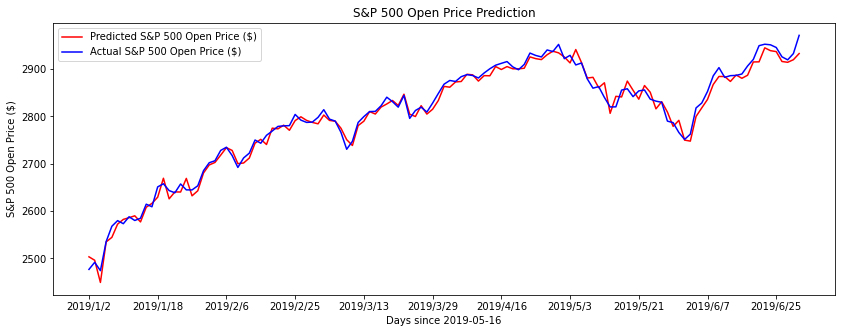

In [25]:
numTicks = 10
tickDifference = dates.shape[0] // numTicks
xTickLocations = np.arange(0, dates.shape[0], tickDifference)
xTicks = []
for i in xTickLocations:
    xTicks.append(dates.iloc[i])

plt.figure(figsize=(14, 5))
plt.plot(y_hat, color='red', label="Predicted S&P 500 Open Price ($)")
plt.plot(y_test, color='blue', label="Actual S&P 500 Open Price ($)")
plt.title('S&P 500 Open Price Prediction')
plt.xticks(xTickLocations, xTicks)
plt.xlabel('Date')
plt.ylabel('S&P 500 Open Price ($)')
plt.legend()
plt.show()

### Price Prediction Performance

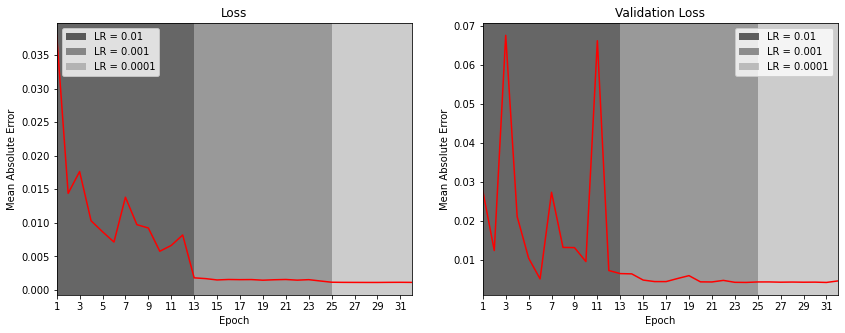

In [26]:
totalLoss = np.concatenate([historyOne.history['loss'], historyTwo.history['loss'], historyThree.history['loss']])
totaValLoss = np.concatenate([historyOne.history['val_loss'], historyTwo.history['val_loss'], historyThree.history['val_loss']])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(totalLoss, color='red')
plt.axvspan(0, numEpochsOne, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(numEpochsOne, numEpochsOne+numEpochsTwo, facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(numEpochsOne+numEpochsTwo, numEpochsOne+numEpochsTwo+numEpochsThree, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, numEpochsOne+numEpochsTwo+numEpochsThree-1)
plt.xticks([2*i for i in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)], [(2*j)+1 for j in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(totaValLoss, color='red')
plt.axvspan(0, numEpochsOne, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(numEpochsOne, numEpochsOne+numEpochsTwo, facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(numEpochsOne+numEpochsTwo, numEpochsOne+numEpochsTwo+numEpochsThree, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, numEpochsOne+numEpochsTwo+numEpochsThree-1)
plt.xticks([2*i for i in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)], [(2*j)+1 for j in range((numEpochsOne+numEpochsTwo+numEpochsThree)//2)])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [27]:
mae = historyThree.history['mean_absolute_error']
mse = historyThree.history['mean_squared_error']
rmse = historyThree.history['root_mean_squared_error']
r2 = historyThree.history['coefficient_of_determination']

print('Mean Absolute Error (MAE): ' + str(mae[-1]))
print('Mean Squared Error (MSE): ' + str(mse[-1]))
print('Root Mean Squared Error (RMSE): ' + str(rmse[-1]))
print('Coefficient of Determination (R2): ' + str(r2[-1]))

Mean Absolute Error (MAE): 0.0011105176527053118
Mean Squared Error (MSE): 3.697361535159871e-06
Root Mean Squared Error (RMSE): 0.0019228524761274457
Coefficient of Determination (R2): 0.9999285340309143


In [28]:
valmae = historyThree.history['val_mean_absolute_error']
valmse = historyThree.history['val_mean_squared_error']
valrmse = historyThree.history['val_root_mean_squared_error']
valr2 = historyThree.history['val_coefficient_of_determination']

print('Validation Mean Absolute Error (MAE): ' + str(valmae[-1]))
print('Validation Mean Squared Error (MSE): ' + str(valmse[-1]))
print('Validation Root Mean Squared Error (RMSE): ' + str(valrmse[-1]))
print('Validation Coefficient of Determination (R2): ' + str(valr2[-1]))

Validation Mean Absolute Error (MAE): 0.004569471348077059
Validation Mean Squared Error (MSE): 3.283120531705208e-05
Validation Root Mean Squared Error (RMSE): 0.005729852244257927
Validation Coefficient of Determination (R2): 0.9190164804458618


### Sentiment Analysis Performance

In [29]:
trainingAccuracy = sentimentHistory.history['acc']
validationAccuracy = sentimentHistory.history['val_acc']

print("Training Accuracy: " + str(trainingAccuracy[-1]))
print("Validation Accuracy: " + str(validationAccuracy[-1]))

Training Accuracy: 0.8384644389152527
Validation Accuracy: 0.7076923251152039


### Trading Strategy Applied to Testing Data

In [30]:
initialBalance = 1000000
actionThreshold = 0.01
sentimentInfluence = 0.005
betProportion = 1

# Random strategy
controlBalance = initialBalance
controlOwnedShares = 0
controlBet = controlBalance / betProportion
controlBuyOrders = 0
controlSellOrders = 0

# Trading the price predictions
balance = initialBalance
ownedShares = 0
bet = balance / betProportion
buyOrders = 0
sellOrders = 0

# Trading the price predictions with sentiment analysis
sentimentBalance = initialBalance
sentimentOwnedShares = 0
sentimentBet = sentimentBalance / betProportion
sentimentBuyOrders = 0
sentimentSellOrders = 0

# Trading the price predictions with true sentiment labels
stagedSentimentBalance = initialBalance
stagedSentimentOwnedShares = 0
stagedSentimentBet = sentimentBalance / betProportion
stagedSentimentBuyOrders = 0
stagedSentimentSellOrders = 0

stagedSentiment = sentiment_y_test[-5:]
stagedSentimentPrediction = sentiment_y_hat[-5:]

def Buy(price, bet, balance, ownedShares):
    if (balance > 0):
            numShares = 0
            if (balance >= bet):
                numShares = bet / price
                balance -= bet
                ownedShares += numShares
            else:
                numShares = balance / price
                balance = 0
                ownedShares += numShares
            # print("BUY - " + str(numShares) + " shares at $" + str(price))
            bet = (balance + (ownedShares * price)) / betProportion
    return bet, balance, ownedShares

def Sell(price, bet, balance, ownedShares):
    if (ownedShares > 0):
        numShares = bet / price
        if (ownedShares >= numShares):
            balance += bet
            ownedShares -= numShares
            # print("SELL - " + str(numShares) + " shares at $" + str(price))
        else:
            value = ownedShares * price
            balance += value
            ownedShares = 0
            # print("SELL - " + str(ownedShares) + " shares at $" + str(price))
        bet = (balance + (ownedShares * price)) / betProportion
    return bet, balance, ownedShares

def GetSentimentScore(daysSentiment):
    positiveScore = 0
    neutralScore = 0
    negativeScore = 0
    for sentiment in daysSentiment:
        positiveScore += sentiment[0]
        neutralScore += sentiment[1]
        negativeScore += sentiment[2]
    score = (positiveScore - negativeScore) / (positiveScore + neutralScore + negativeScore)
    return score

# Random trading strategy
for i in range(len(y_hat)-1):
    if (randint(0, 1) == 0): # ! Buy
        controlBet, controlBalance, controlOwnedShares = Buy(y_test[i], controlBet, controlBalance, controlOwnedShares)
    else: # ! Sell
        controlBet, controlBalance, controlOwnedShares = Sell(y_test[i], controlBet, controlBalance, controlOwnedShares)

# Trading strategy based on price prediction and sentiment analysis
for i in range(len(y_hat)-1):
    # Get sentiment score
    sentimentScore = 0
    if (i <= 25):
        sentimentScore = GetSentimentScore([stagedSentimentPrediction[0]])
        stagedSentimentScore = GetSentimentScore([stagedSentiment[0]])
    elif (i <= 50):
        sentimentScore = GetSentimentScore([stagedSentimentPrediction[1]])
        stagedSentimentScore = GetSentimentScore([stagedSentiment[1]])
    elif (i <= 75):
        sentimentScore = GetSentimentScore([stagedSentimentPrediction[2]])
        stagedSentimentScore = GetSentimentScore([stagedSentiment[2]])
    elif (i <= 100):
        sentimentScore = GetSentimentScore([stagedSentimentPrediction[3]])
        stagedSentimentScore = GetSentimentScore([stagedSentiment[3]])
    elif (i <= 125):
        sentimentScore = GetSentimentScore([stagedSentimentPrediction[4]])
        stagedSentimentScore = GetSentimentScore([stagedSentiment[4]])
    
    currentPrice = y_test[i]
    predictedPrice = y_hat[i+1]
    difference = predictedPrice - currentPrice
    percentageChange = difference / currentPrice

    # No sentiment
    if (abs(percentageChange) < actionThreshold): # ! Hold
        pass
    elif (currentPrice < predictedPrice): # ! Buy
        bet, balance, ownedShares = Buy(y_test[i], bet, balance, ownedShares)
    elif (currentPrice > predictedPrice): # ! Sell
        bet, balance, ownedShares = Sell(y_test[i], bet, balance, ownedShares)

    # With sentiment predictions
    if (abs(percentageChange + (sentimentScore * sentimentInfluence)) < actionThreshold): # ! Hold
        pass
    elif (currentPrice < predictedPrice): # ! Buy
        sentimentBet, sentimentBalance, sentimentOwnedShares = Buy(y_test[i], sentimentBet, sentimentBalance, sentimentOwnedShares)
    elif (currentPrice > predictedPrice): # ! Sell
        sentimentBet, sentimentBalance, sentimentOwnedShares = Sell(y_test[i], sentimentBet, sentimentBalance, sentimentOwnedShares)

    # With sentiment labels
    if (abs(percentageChange + (stagedSentimentScore * sentimentInfluence)) < actionThreshold): # ! Hold
        pass
    elif (currentPrice < predictedPrice): # ! Buy
        stagedSentimentBet, stagedSentimentBalance, stagedSentimentOwnedShares = Buy(y_test[i], stagedSentimentBet, stagedSentimentBalance, stagedSentimentOwnedShares)
    elif (currentPrice > predictedPrice): # ! Sell
        stagedSentimentBet, stagedSentimentBalance, stagedSentimentOwnedShares = Sell(y_test[i], stagedSentimentBet, stagedSentimentBalance, stagedSentimentOwnedShares)

controlTotalShareValue = controlOwnedShares * y_test[-1]
controlFinalBalance = controlBalance + controlTotalShareValue
controlProfit = controlFinalBalance-initialBalance
controlBalancePercentageChange = ((controlFinalBalance-initialBalance)/initialBalance) * 100

totalShareValue = ownedShares * y_test[-1]
finalBalance = balance + totalShareValue
profit = finalBalance-initialBalance
balancePercentageChange = ((finalBalance-initialBalance)/initialBalance) * 100

sentimentTotalShareValue = sentimentOwnedShares * y_test[-1]
sentimentFinalBalance = sentimentBalance + sentimentTotalShareValue
sentimentProfit = sentimentFinalBalance-initialBalance
sentimentBalancePercentageChange = ((sentimentFinalBalance-initialBalance)/initialBalance) * 100

stagedSentimentTotalShareValue = stagedSentimentOwnedShares * y_test[-1]
stagedSentimentFinalBalance = stagedSentimentBalance + stagedSentimentTotalShareValue
stagedSentimentProfit = stagedSentimentFinalBalance-initialBalance
stagedSentimentBalancePercentageChange = ((stagedSentimentFinalBalance-initialBalance)/initialBalance) * 100

pricePercentageChange = ((y_test[-1]-y_test[0])/y_test[0]) * 100

print("----------------------------------------------------------------")

print("Trading over " + str(y_hat.shape[0]) + " days")
print("Initial Balance: $" + str(initialBalance))

print("----------------------------------------------------------------")

print("Random Trading Strategy")
# print("Final Balance: $" + str(controlFinalBalance))
print("Profit: $" + str(controlProfit))
print("Balance Percentage Change: " + str(controlBalancePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Buying on day one and holding")
print("Profit: $" + str(initialBalance * pricePercentageChange))
print("Balance Percentage Change: " + str(pricePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Trading strategy based on price predictions")
# print("Final Balance: $" + str(finalBalance))
print("Profit: $" + str(profit))
print("Balance Percentage Change: " + str(balancePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Trading based on price predictions and sentiment predictions")
# print("Final Balance: $" + str(sentimentFinalBalance))
print("Profit: $" + str(sentimentProfit))
print("Balance Percentage Change: " + str(sentimentBalancePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Trading strategy based on price predictions and sentiment label")
# print("Final Balance: $" + str(stagedSentimentFinalBalance))
print("Profit: $" + str(stagedSentimentProfit))
print("Balance Percentage Change: " + str(stagedSentimentBalancePercentageChange) + "%")

print("----------------------------------------------------------------")

----------------------------------------------------------------
Trading over 125 days
Initial Balance: $1000000
----------------------------------------------------------------
Random Trading Strategy
Profit: $68852.99743165215
Balance Percentage Change: 6.885299743165215%
----------------------------------------------------------------
Buying on day one and holding
Profit: $19961967.84708542
Balance Percentage Change: 19.96196784708542%
----------------------------------------------------------------
Trading strategy based on price predictions
Profit: $230303.30983596854
Balance Percentage Change: 23.03033098359685%
----------------------------------------------------------------
Trading based on price predictions and sentiment predictions
Profit: $247801.44382919045
Balance Percentage Change: 24.780144382919044%
----------------------------------------------------------------
Trading strategy based on price predictions and sentiment label
Profit: $288265.1180848689
Balance Percentag